In [19]:
from tensorflow.keras.utils import image_dataset_from_directory


In [20]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("smaranjitghose/corn-or-maize-leaf-disease-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\gharr\.cache\kagglehub\datasets\smaranjitghose\corn-or-maize-leaf-disease-dataset\versions\1


In [ ]:
data = r'C:\Users\gharr\.cache\kagglehub\datasets\smaranjitghose\corn-or-maize-leaf-disease-dataset\versions\1\data'
import tensorflow as tf
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    data,
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.2,
    subset="training",
    seed=42
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    data,
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.2,
    subset="validation",
    seed=42
)

class_names = train_ds_raw.class_names

print("Classes:", class_names)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds_raw.map(lambda x, y: (x/255.0, y)).cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds_raw.map(lambda x, y: (x/255.0, y)).cache().prefetch(AUTOTUNE)



Found 4188 files belonging to 4 classes.
Using 3351 files for training.
Found 4188 files belonging to 4 classes.
Using 837 files for validation.
Classes: ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


AttributeError: '_PrefetchDataset' object has no attribute 'class_names'

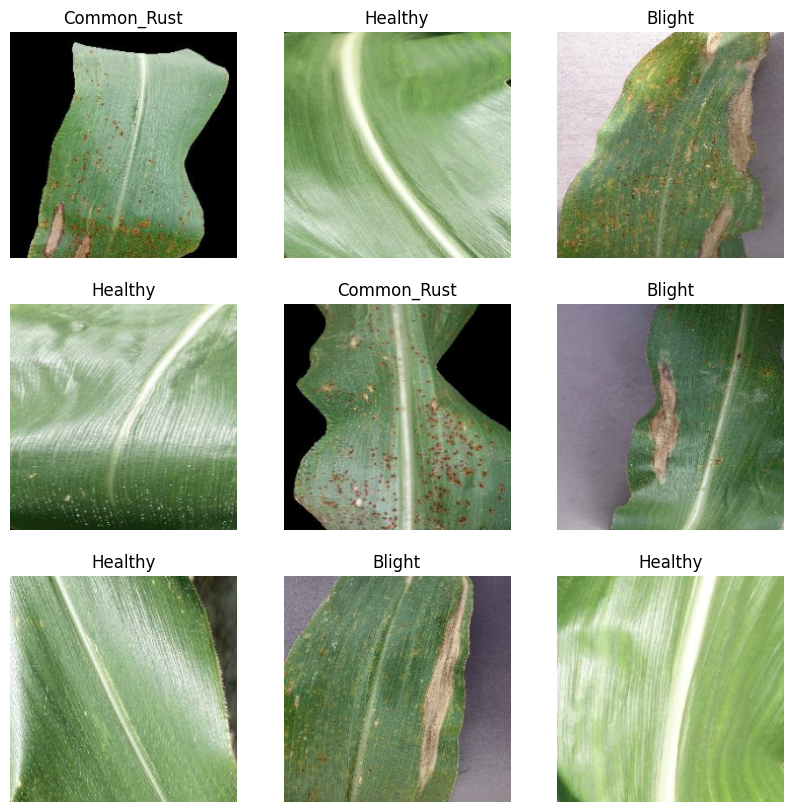

In [22]:
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")
    break


In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)


In [24]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False  # freeze base layers for faster training


In [26]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=15)


Epoch 1/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 67s 583ms/step - accuracy: 0.8669 - loss: 0.3240 - val_accuracy: 0.8996 - val_loss: 0.2706
Epoch 2/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 57s 544ms/step - accuracy: 0.9400 - loss: 0.1630 - val_accuracy: 0.9092 - val_loss: 0.2434
Epoch 3/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 58s 551ms/step - accuracy: 0.9445 - loss: 0.1385 - val_accuracy: 0.9116 - val_loss: 0.2546
Epoch 4/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 55s 526ms/step - accuracy: 0.9603 - loss: 0.0990 - val_accuracy: 0.9271 - val_loss: 0.2199
Epoch 5/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 53s 510ms/step - accuracy: 0.9711 - loss: 0.0756 - val_accuracy: 0.9200 - val_loss: 0.2312
Epoch 6/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 53s 510ms/step - accuracy: 0.9767 - loss: 0.0647 - val_accuracy: 0.9140 - val_loss: 0.2378
Epoch 7/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 55s 525ms/step - accuracy: 0.9833 - loss: 0.0476 - val_accuracy: 0.9307 - val_loss: 0.2329
Epoch 8/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 58s 555ms/step - accuracy: 0.9928 - loss: 0

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

Y_pred = model.predict(val_ds)
y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(val_ds.class_names, y_pred, target_names=val_ds.class_indices.keys()))


27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 427ms/step


AttributeError: '_PrefetchDataset' object has no attribute 'class_indices'